# Process GM-SEUS for All Final Attributes
* This includes: Installation Year, Ground Cover Ratio, Moduel Type, Agrivoltaic Type, Module Efficiency, and Installed Capacity 

# Import Libraries and Variables

In [6]:
# Import libraries
import numpy as np
import pandas as pd
import geopandas as gpd
import os 
from shapely.ops import nearest_points
from sklearn.linear_model import LinearRegression

# Import matplotlib
import matplotlib.pyplot as plt

# Load config file
def load_config(filename):
    config = {}
    with open(filename, 'r') as f:
        for line in f:
            # Strip whitespace and split by '='
            key, value = line.strip().split('=')
            # Try to convert to numeric values if possible
            try:
                value = float(value) if '.' in value else int(value)
            except ValueError:
                pass  # Leave as string if not a number
            config[key] = value
    return config

In [ ]:
# Set version
version = 'v1.0'

# Set folder paths
wd = r'S:\Users\stidjaco\R_files\BigPanel'
downloaded_path = os.path.join(wd, r'Data\Downloaded')
derived_path = os.path.join(wd, r'Data\Derived')
derivedTemp_path = os.path.join(derived_path, r'intermediateProducts')
figure_path = os.path.join(wd, r'Figures')

# Set LandTrendr file paths
lt_folder = os.path.join(derived_path, r'LandTrendrGEEInstallYear')

# Set a GM-SEUS array path for acquiring installation year (exploded grouped arrays -- SAM) and panel path
gmseusArraysInstYrPath = os.path.join(derivedTemp_path, r'GMSEUS_Arrays_instYr.shp')
gmseusPanelsCombinedPath = os.path.join(derivedTemp_path, r'GMSEUS_Panels_ExistingAndNAIP.shp')

# Set gmseusArraysInstYr spatially joined with point data path, LandTrendr data path, and final instYr path
gmseusArraysInstYrPathPointCheckedPath = os.path.join(derivedTemp_path, r'GMSEUS_Arrays_instYr_pointChecked.shp')
lt_data_path = os.path.join(derivedTemp_path, r'GMSEUS_Arrays_instYr_LandTrendr.csv')
gmseusInstYrFinalPath = os.path.join(derivedTemp_path, r'GMSEUS_Arrays_instYr_final.shp')

# Set a final gmseus arrays and panel path
gmseusArraysFinalPath = os.path.join(derived_path, r'GMSEUS/GMSEUS_Arrays_Final.shp')
gmseusPanelsFinalPath = os.path.join(derived_path, r'GMSEUS/GMSEUS_Panels_Final.shp')

# Set existing dataset paths
uspvdb_path = os.path.join(derivedTemp_path, r'uspvdb_poly.shp')
ccvpv_path = os.path.join(derivedTemp_path, r'ccvpv_poly.shp')
cwsd_path = os.path.join(derivedTemp_path, r'cwsd_poly.shp')
osm_path = os.path.join(derivedTemp_path, r'osm_poly.shp')
sam_path = os.path.join(derivedTemp_path, r'sam_poly.shp')
inspire_path = os.path.join(derivedTemp_path, r'inspire_point.shp')
lbnlUss_path = os.path.join(derivedTemp_path, r'lbnlUss_point.shp')
gppdb_path = os.path.join(derivedTemp_path, r'gppdb_point.shp')
gspt_path = os.path.join(derivedTemp_path, r'gspt_point.shp')
pvdaq_path = os.path.join(derivedTemp_path, r'pvdaq_point.shp')
solarPaces_path = os.path.join(derivedTemp_path, r'solarPaces_point.shp')

# Set Tracking the Sun file path
tts_path = os.path.join(downloaded_path, r'TrackingTheSun\TTS_LBNL_public_file_21-Aug-2024_all.csv')

# Set USPVDB file path
uspvdb_path = os.path.join(derivedTemp_path, r'uspvdb_poly.shp')

# Load the config from the text file
config = load_config('config.txt')

# Load variables
overlapDist = config['overlapDist'] # 190 meters, Set a overlap distance for checking if points/mismatched geometries between Solar PV datasets are duplicates
minPanelRowArea = config['minPanelRowArea'] # 15 m2, minimum area for a single panel row from the 1st percentile panel area from Stid et al., 2022
maxPanelRowArea = config['maxPanelRowArea'] # 254 m2 95th perccentile for a single panel row from Stid et al., 2022. MSU Solar Carport has max 1890m2
minNumPanelRows = config['minNumPanelRows'] # 3 panels, minimum number of panels rows to form a ground mounted solar array, definition from Stid et al., 2022
minPmArRatio = config['minPmArRatio'] # 18.8%, 20% was minimum ratio of panel perimeter to area ratio for panels from Stid et al., 2022, MSU Solar Carport has min 18.9%
panelArrayBuff = config['panelArrayBuff'] # 10m buffer, 20m maximum distance between panel rows to form an array. We used 5m in Stid et al., 2022, but there are lower packing factors at greater latitudes (nativeID: '1229957948')
arrayArrayBuff = config['arrayArrayBuff'] # 20m buffer, 40m maximum distance between arrays subsections of the same mount type to form a complete array. In Stid et al., 2022, we used 50m, but we checked for same installation year in addition to mount type.
lengthRatioThresh = config['lengthRatioThresh']  # If length ratio < 3.0, set to dual_axis or else fixed_axis_diagonal, else single- or fixed-axis
areaRatioThresh = config['areaRatioThresh']  # If area ratio < 0.15, set to fixed_diag_axis, else dual_axis

# Helper Functions

In [8]:
# Function to assign mount type to solar panel-rows based on azimuth and panel geometry. Also returns all relevant design parameters for each panel-row. Requires the setting of a length ratio threshold and an area ratio threshold.
def assignMountType(feature):
    # Estimate azimuth of solar panel-row short edge
    def getAzimuth(feature):
        # Get the minimum bounding rectangle (oriented)
        mbr = feature.geometry.minimum_rotated_rectangle
        
        # Get the coordinates of the MBR
        coords = list(mbr.exterior.coords)
        
        # Calculate distances between consecutive vertices to determine lengths of edges
        edge_lengths = []
        for i in range(len(coords) - 1):  # last point is a duplicate of the first
            p1, p2 = coords[i], coords[i + 1]
            dist = np.sqrt((p2[0] - p1[0])**2 + (p2[1] - p1[1])**2)
            # Set a tempArea 
            # panels = panels**2 + (p2[1] - p1[1])**2)
            edge_lengths.append(dist)
        
        # Identify shorter and longer sides
        short_edge_index = np.argmin(edge_lengths[:2])  # first two edges are enough to find shorter side
        
        # Use the shorter edge for azimuth calculation
        p1, p2 = coords[short_edge_index], coords[short_edge_index + 1]
        
        # Calculate the azimuth (angle relative to north, counterclockwise)
        delta_x = p2[0] - p1[0]
        delta_y = p2[1] - p1[1]

        # Azimuth relative to north (y-axis)
        angle_radians = np.arctan2(delta_x, delta_y)
        angle_degrees = np.degrees(angle_radians)

        # Normalize the angle to 0-360 degrees
        if angle_degrees < 0:
            angle_degrees += 360
        if angle_degrees > 360:
            angle_degrees -= 360
        
        # In the northern hemisphere, the a solar panel-row azimuth angle will never be towards the north (270 to 360 and 0 to 90 degrees). Therefore, if the azimuth is between 270 and 360 or 0 and 90, we need to add 180 degrees to the azimuth to get the correct orientation of the panel.
        if 270 <= angle_degrees <= 360 or 0 <= angle_degrees <= 90:
            angle_degrees += 180

        return angle_degrees
    
    # Get the ratio of the long edge to the short edge of the panel (and the lengths of the short and long edges)
    def getLengthRatio(feature):
        # Get the minimum bounding rectangle (oriented)
        mbr = feature.geometry.minimum_rotated_rectangle
        
        # Get the coordinates of the MBR
        coords = list(mbr.exterior.coords)
        
        # Calculate distances between consecutive vertices
        edge_lengths = []
        for i in range(len(coords) - 1):  # last point is a duplicate of the first
            p1, p2 = coords[i], coords[i + 1]
            dist = np.sqrt((p2[0] - p1[0])**2 + (p2[1] - p1[1])**2)
            edge_lengths.append(dist)
        
        # Sort the edge lengths to identify short and long sides
        sorted_lengths = sorted(edge_lengths[:2])  # Only need two sides (since rectangle has equal opposite sides)
        short_edge = sorted_lengths[0]
        long_edge = sorted_lengths[1]
        
        # Calculate the ratio of long edge to short edge
        length_ratio = long_edge / short_edge
        return length_ratio, short_edge, long_edge
    
    # Run the geteAzimuth function to get the azimuth of each panel row, getLengthRatio function to get the long and short edge ratio, and the and getAreaRatio function to get the panel area to bounding box ratio
    azimuth = getAzimuth(feature)
    length_ratio, short_edge, long_edge = getLengthRatio(feature)

    # Assign mount type based on azimuth and area ratio 
    # Fixed-axis: If the azimuth is within 60 degrees of S, and length ratio is greater than 2.5
    # Single-axis: If the azimuth is within 30 degrees of E or W (in southward radians), and length ratio is greater than 2.5
    # Dual-axis: Any azimuth and the length ratio is less than 2.5
    def classify_mount_type(azimuth, length_ratio):
        # Check if azimuth is within 60 degrees to to S (180) -- Should never be north
        if (abs(azimuth - 180) <= 60):
            if length_ratio >= lengthRatioThresh:
                return 'fixed_axis'
        
        # Check if azimuth is within 30 degrees of close to E (90) or W (270)
        elif (abs(azimuth - 90) <= 30 or abs(azimuth - 270) <= 30):
            if length_ratio >= lengthRatioThresh:
                return 'single_axis'
        
        # Otherwise, classify as dual-axis
        if length_ratio < lengthRatioThresh: # if area_ratio > areaRatioThresh and length_ratio < lengthRatioThresh:
            return 'dual_axis'
        
        # Default case -- no panel-rows should be missed, but default to fixed-axis
        return 'fixed_axis'
    
    # Classify the mount type
    mount = classify_mount_type(azimuth, length_ratio)

    # Assign mount type based on azimuth, and return the mount type, azimuth, length ratio, short edge, and long edge
    return mount, azimuth, length_ratio, short_edge, long_edge

# Function to check for and remove erroneous geometries in arrays
def checkArrayGeometries(arrays): 
    # For a collection of reasons, array boundaries may contain erroneous geometries that result in a near-zero area, linestrings, or points. 
    # To check for and remove these, we'll explode arrays, calculate a temporary area, remove subarrays that are less than a minimum area, then dissolve by tempID.
    arrays['tempDissolveID'] = (1 + np.arange(len(arrays)))  # Create a temporary ID for dissolving
    arrays = arrays.explode(index_parts=False)
    arrays['tempArea'] = arrays['geometry'].area
    arrays = arrays[arrays['tempArea'] >= minPanelRowArea]
    arrays = arrays.dissolve(by=['tempDissolveID'], as_index=False)
    arrays = arrays.drop(columns=['tempArea', 'tempDissolveID'])
    arrays = arrays.reset_index(drop=True)
    return arrays

# Function to create an array from a set of panel rows based on the distance between them
def createArrayFromPanels(panels, buffDist, dissolveID, areaID='area'):
 
    # Count panels per group before dissolving
    panelCounts = panels.groupby(dissolveID).size().reset_index(name='numPanels')

    # Get the total area of the panels within each group (sum of area column). 
    panelAreas = panels.groupby(dissolveID)[areaID].sum().reset_index(name='pnlArea')
    
    # Buffer the geometries by buffDist, dissovle boundaries, and unbuffer by buffDist* -1. Assign the number of objects being dissovle into a numPanels column.
    arrays = panels.copy()
    arrays['geometry'] = arrays.buffer(buffDist)
    arrays = arrays.dissolve(by=[dissolveID], as_index=False)
    arrays['geometry'] = arrays.buffer(buffDist * -1)

    # Merge the panel counts and panel areas back into the dissolved array DataFrame. Select only the dissolveID and respective columns in the right df
    arrays = arrays.merge(panelCounts[[dissolveID, 'numPanels']], on=dissolveID, how='left')
    arrays = arrays.merge(panelAreas[[dissolveID, 'pnlArea']], on=dissolveID, how='left')

    # Due to the buffering and unbuffering, some mulitpolygons contain erroneous geometries that result in a near-zero area, linestrings, or points. Remove these.
    arrays = checkArrayGeometries(arrays)

    # Reset index
    arrays = arrays.reset_index(drop=True)
    return arrays

# Create a function to calculate the inter-row spacing for each panel in the same array in the direction of the azimuth (for fixed-axis and single-axis arrays) and any direction (for dual-axis arrays)
def calculateRowSpacing(gdf):
    # Set columns
    azimuth_col = 'rowAzimuth'
    row_mount_col = 'rowMount'
    group_col = 'arrayID'
    geometry_col = 'geometry'
    panel_col = 'panelID'

    # Initialize with NaN for no results
    gdf.loc[:, 'rowSpace'] = np.nan

    # For the sake of printing progress, order gdf by increasing arrayID
    gdf = gdf.sort_values(group_col)

    # Define a function to filter candidates based on azimuth direction
    def filter_candidates(base_azimuth, candidate_azimuths, row_mount):
        # Filter candidates based on azimuth direction.
        if row_mount in ['fixed_axis', 'single_axis']:
            # Define the valid azimuth directions (forward and backward vectors)
            forward_azimuth = base_azimuth % 360
            backward_azimuth = (base_azimuth + 180) % 360

            # Allow some tolerance for alignment (e.g., ±15 degrees)
            tolerance = 15
            valid = (
                (np.abs(candidate_azimuths - forward_azimuth) <= tolerance) |
                (np.abs(candidate_azimuths - backward_azimuth) <= tolerance)
            )
            return valid
        # For dual_axis, allow all candidates
        return np.full(len(candidate_azimuths), True)

    # Iterate over each array
    for arrayID, group in gdf.groupby(group_col):
        # Because this is an intensive operation, print progress as a percentage. Only print every 1%, based on group_col as a proportion of the number of unique ids in group_col.
        uniqueIDs = gdf[group_col].nunique()
        currentID = arrayID # gdf.loc[gdf.index[0], group_col]
        if currentID % (uniqueIDs // 20) == 0:
            print(f'{currentID} of {uniqueIDs} ({100 * currentID / uniqueIDs:.0f}%) in progress')
        
        if len(group) < 2:
            continue  # Skip groups with only one polygon
        group = group.copy()  # Copy for memory safety

        # Build a spatial index for the current group
        spatial_index = group.sindex

        results = []
        for idx, row in group.iterrows():
            base_geom = row[geometry_col]
            base_azimuth = row[azimuth_col]
            row_mount = row[row_mount_col]

            # Calculate distances to all other geometries in the group within panelArrayBuff * 2 + 1 (21m, just to be sure we capture an panel from the buffer-dissolve-erode method). 
            base_geom_buffered = base_geom.buffer(panelArrayBuff * 2 + 1)

            # Query the spatial index for geometries within the buffer
            possible_matches_index = list(spatial_index.intersection(base_geom_buffered.bounds))
            possible_matches = group.iloc[possible_matches_index]

            # Exclude the current geometry (self-match)
            candidates = possible_matches[possible_matches.index != idx]

            # Further refine candidates by checking if they fall within the buffered area
            candidates = candidates[candidates[geometry_col].intersects(base_geom_buffered)]

            # Filter candidates by azimuth direction (valid)
            if not candidates.empty:
                # Get the valid candidates
                valid = filter_candidates(base_azimuth, candidates[azimuth_col], row_mount)
                valid_candidates = candidates[valid].copy() # Copy for memory safety
                valid_candidates['distance_to_base'] = valid_candidates[geometry_col].apply(base_geom.distance)

                # Calculate distances to valid candidates
                if not valid_candidates.empty:
                    # Use a list comprehension to calculate distances and ensure numeric output
                    distances = [base_geom.distance(candidate_geom) for candidate_geom in valid_candidates[geometry_col]]
                    valid_candidates = valid_candidates.copy()  # Avoid SettingWithCopyWarning
                    valid_candidates['distance_to_base'] = distances

                    # Ensure removed self interseciton and set distance max to panelArrayBuff*2 (20m). If distance to base is greater, set to 20. Copy for memory safety.
                    valid_candidates = valid_candidates[valid_candidates['distance_to_base'] > 0]
                    valid_candidates['distance_to_base'] = valid_candidates['distance_to_base'].apply(lambda x: panelArrayBuff * 2 if x > panelArrayBuff * 2 else x)

                    # Get the minimum distance among valid candidates
                    if not valid_candidates.empty:
                        min_distance = valid_candidates['distance_to_base'].min()
                        results.append((idx, min_distance))

        # Update distances in the original GeoDataFrame
        for idx, min_distance in results:
            gdf.loc[idx, 'rowSpace'] = min_distance

    return gdf

# Get array mount type from the majority class, or create a mixed class if no majority. Result is fixed_axis, single_axis, dual_axis, or mixed_[unique_classes] if there is not a 90% majority class.
def getArrayMount(group):
    counts = group.value_counts()
    total = counts.sum()
    # Check if any class makes up more than 75% of the total
    if (counts / total).max() > 0.75:
        return counts.idxmax()  # Majority class
    else:
        # If mixed, create the "mixed_" label with sorted unique classes that are only the first letter of each class in the group
        unique_classes = ''.join(sorted({g[0] for g in group.unique()}))
        return f'mixed_{unique_classes}'
    
# Get array azimuth from panel-row azimuths depdending on mount. Fixed- and dual-axis arrays have an avgAzimuth of the median of rowAzimuth. Single-axis arrays have an avgAzimuth of the median of rowAzimuth IF rowAzimuth is  + 90 degrees. Mixed arrays should be ignored, but have an avearge azimuth of the median of rowAzimuth.
def getArrayAzimuth(group):
    mount_type = group['rowMount'].iloc[0]
    row_azimuth = group['rowAzimuth']
    if mount_type in ['fixed_axis', 'dual_axis']:
        # Median for fixed and dual-axis
        return np.median(row_azimuth)
    elif mount_type == 'single_axis':
        # If single-axis, azimuths could be east (90 to 120) or west (240 to 270). Separate by east and west, take the median for each, then convert the west average azimuth to the equivalent southfacing east average azmiuth, and get the average of the two.
        # For example, if west azimtuh average is 260 and east azimuth average if 105, the adjusted west azimuth average would be 90+(270-westAvgAzimtuh) = 100. The average azimuth would be (100+105)/2 = 102.5
        east_azimuths = row_azimuth[(row_azimuth >= 90) & (row_azimuth <= 120)]
        west_azimuths = row_azimuth[(row_azimuth >= 240) & (row_azimuth <= 270)]
        east_avg = np.median(east_azimuths)
        west_avg = np.median(west_azimuths)
        west_avg_adj = 90 + (270 - west_avg)
        return (east_avg + west_avg_adj) / 2
    elif mount_type.startswith('mixed_'):
        # Median for mixed arrays
        return np.median(row_azimuth)
    else:
        return np.nan  # Default for unexpected cases
    
# Define a function that groups solar panels by mount type and proximity
def groupArrayByMountAndProximity(gdf, buffer_distance):
    # Set a temporary gdf to buffer
    gdfBuffer = gdf.copy()

    # Create a buffered version of the geometries
    gdfBuffer['geometry'] = gdfBuffer.buffer(buffer_distance)

    # Dissolve by mount
    gdfBuffer = gdfBuffer.dissolve(by = 'mount')

    # Explode the dissolved gdf
    gdfBuffer = gdfBuffer.explode(index_parts=False).reset_index(drop = True)

    # Assign a temp ID to the gdfBuffer
    gdfBuffer['arrayID'] = range(0, len(gdfBuffer))

    # Assign each panel the corresponding arrayID and total panel num in array by spatial join.
    gdfOut = gpd.sjoin(gdf, gdfBuffer[['arrayID', 'geometry']], how='left', predicate='intersects').drop(columns='index_right')

    # Group polygons into multiploygons by array ID. Keep the column
    gdfOut = gdfOut.dissolve(by = 'arrayID').reset_index()

    # Drop the arrayID column
    gdfOut = gdfOut.drop(columns='arrayID', errors='ignore')
    return gdfOut

# Estimate Installation Year and Build Final Array Dataset

## Check Existing Datasets for Installation Year
With a completed installation year, we can finish the GM-SEUS Array Dataset construction. 

We grabbed installation year for array polygon datasets in `script1` if they existed (USPVDB, CCVPV, OSM, SAM).

Those are (in order of preference):
* *USPVDB*: `oper_year`
* *CCVPV*: `inst_Yr`
* *CWSD*: `year_right` (derived from Sentinel-2, dropped any year prior to 2018 to prevent first year of S2 bias)
* *OSM*: `start_date`
* *SAM*: `constructed_before` & `constructed_after` (derived from Sentinel-2, dropped any year prior to 2018 to prevent first year of S2 bias)

We have not done this for other value added datasets. Those are (in order of preference): 
* *InSPIRE:* `Year Installed`
* *LBNL-USS:* `Solar COD Year`
* *SolarPACES:* `Year_operational`
* *GSPT:* `Start year`
* *GPPDB:* `commissioning_year`
* *PVDAQ:* `system_year` (not installation year so we omit)

We've already prepared these in `script1` as well and exported source dataset specific point shape files to reference

In [ ]:
# Call GM-SEUS array data
gmseusArraysInstYr = gpd.read_file(gmseusArraysInstYrPath)

# Set a tempID to gmseusArrays
gmseusArraysInstYr['tempID'] = (1 + np.arange(len(gmseusArraysInstYr)))

# Fill instYr NaN values with -9999
gmseusArraysInstYr['instYr'] = gmseusArraysInstYr['instYr'].fillna(-9999)

# Select gmseus arrays where instYr is -9999
gmseusArrays_noInstYr = gmseusArraysInstYr[gmseusArraysInstYr['instYr'] == -9999]
gmseusArrays_noInstYr = gmseusArrays_noInstYr.reset_index(drop=True)

# Print the total number of arrays with an installation year (instYr != -9999)
print('Number of arrays with installation year:', gmseusArraysInstYr[gmseusArraysInstYr['instYr'] != -9999].shape[0])

# Print the total number of arrays without an installation year
print('Number of arrays without an installation year:', gmseusArrays_noInstYr.shape[0])

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Get array data with installation year

# We do not necessarily capture this in script1 because that script builds a datafrmae based on spatial quality, not installation year presence or quality, so the attribute is not saved. We will need to re-import and append the data here.

# Call poly dataset (except for ccvpv since our LandTrendr method is the improved version)
uspvdb = gpd.read_file(uspvdb_path)
#ccvpv = gpd.read_file(ccvpv_path)
cwsd = gpd.read_file(cwsd_path)
osm = gpd.read_file(osm_path)
sam = gpd.read_file(sam_path)

# Filter where instYr is between 1983 and 2024
boundYears = [1983, 2024]
uspvdb = uspvdb[(uspvdb['instYr'] >= boundYears[0]) & (uspvdb['instYr'] <= boundYears[1])]
#ccvpv = ccvpv[(ccvpv['instYr'] >= boundYears[0]) & (ccvpv['instYr'] <= boundYears[1])]
cwsd = cwsd[(cwsd['instYr'] >= boundYears[0]) & (cwsd['instYr'] <= boundYears[1])]
osm = osm[(osm['instYr'] >= boundYears[0]) & (osm['instYr'] <= boundYears[1])]
sam = sam[(sam['instYr'] >= boundYears[0]) & (sam['instYr'] <= boundYears[1])]

# Merge into a single dataset
polyData = pd.concat([uspvdb, sam, cwsd, osm]) # ccvpv_unique

# Print the number of arrays in each dataset after filtering
print('Number of arrays in point datasets with installation year:', len(polyData))

# Get unique polygon data with an installation year 
# For installation year specifically, use the following order of priority: uspvdb, ccvpv, sam, cwsd, osm
uspvdb_unique = uspvdb
#ccvpv_unique = ccvpv[~ccvpv.intersects(uspvdb.unary_union)]
sam_unique = sam[~sam.intersects(uspvdb.unary_union)]
#sam_unique = sam_unique[~sam_unique.intersects(ccvpv.unary_union)]
cwsd_unique = cwsd[~cwsd.intersects(uspvdb.unary_union)]
#cwsd_unique = cwsd_unique[~cwsd_unique.intersects(ccvpv.unary_union)]
cwsd_unique = cwsd_unique[~cwsd_unique.intersects(sam.unary_union)]
osm_unique = osm[~osm.intersects(uspvdb.unary_union)]
#osm_unique = osm_unique[~osm_unique.intersects(ccvpv.unary_union)]
osm_unique = osm_unique[~osm_unique.intersects(sam.unary_union)]
osm_unique = osm_unique[~osm_unique.intersects(cwsd.unary_union)]

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Get point data with installation year

# Call inspire, lbnlUss, gppdb, gspt, pvdaq, and solarPaces datasets
inspire = gpd.read_file(inspire_path)
lbnlUss = gpd.read_file(lbnlUss_path)
solarPaces = gpd.read_file(solarPaces_path)
gspt = gpd.read_file(gspt_path)
gppdb = gpd.read_file(gppdb_path)

# Filter where instYr is between 1983 and 2024
inspire = inspire[(inspire['instYr'] >= boundYears[0]) & (inspire['instYr'] <= boundYears[1])]
lbnlUss = lbnlUss[(lbnlUss['instYr'] >= boundYears[0]) & (lbnlUss['instYr'] <= boundYears[1])]
solarPaces = solarPaces[(solarPaces['instYr'] >= boundYears[0]) & (solarPaces['instYr'] <= boundYears[1])]
gspt = gspt[(gspt['instYr'] >= boundYears[0]) & (gspt['instYr'] <= boundYears[1])]
gppdb = gppdb[(gppdb['instYr'] >= boundYears[0]) & (gppdb['instYr'] <= boundYears[1])]

# Merge into a single dataset
pointData = pd.concat([inspire, lbnlUss, solarPaces, gspt, gppdb])

# Print the number of arrays in each dataset after filtering
print('Number of arrays in point datasets with installation year:', len(pointData))

# Buffer the point data by 100 meters (overlapDist) account for potential misalignment of point data
inspire_buffer = inspire.copy()
inspire_buffer['geometry'] = inspire_buffer.buffer(overlapDist)
lbnlUss_buffer = lbnlUss.copy()
lbnlUss_buffer['geometry'] = lbnlUss_buffer.buffer(overlapDist)
solarPaces_buffer = solarPaces.copy()
solarPaces_buffer['geometry'] = solarPaces_buffer.buffer(overlapDist)
gspt_buffer = gspt.copy()
gspt_buffer['geometry'] = gspt_buffer.buffer(overlapDist)
gppdb_buffer = gppdb.copy()
gppdb_buffer['geometry'] = gppdb_buffer.buffer(overlapDist)

# Get point data that is not within 190 meters of other point data. 
# Spatial quality is in theory the same for these, given percieved dataset quality
# Use the following order of priority: InSPIRE, SolarPACES, GSPT, GPPDB
inspire_unique = inspire_buffer
lbnlUss_unique = lbnlUss_buffer[~lbnlUss_buffer.intersects(inspire_buffer.unary_union)]
solarPaces_unique = solarPaces_buffer[~solarPaces_buffer.intersects(inspire_buffer.unary_union)]
solarPaces_unique = solarPaces_unique[~solarPaces_unique.intersects(lbnlUss_buffer.unary_union)]
gspt_unique = gspt_buffer[~gspt_buffer.intersects(inspire_buffer.unary_union)]
gspt_unique = gspt_unique[~gspt_unique.intersects(lbnlUss_buffer.unary_union)]
gspt_unique = gspt_unique[~gspt_unique.intersects(solarPaces_buffer.unary_union)]
gppdb_unique = gppdb_buffer[~gppdb_buffer.intersects(inspire_buffer.unary_union)]
gppdb_unique = gppdb_unique[~gppdb_unique.intersects(lbnlUss_buffer.unary_union)]
gppdb_unique = gppdb_unique[~gppdb_unique.intersects(solarPaces_buffer.unary_union)]
gppdb_unique = gppdb_unique[~gppdb_unique.intersects(gspt.unary_union)]

# Reset all indices
inspire_unique = inspire_unique.reset_index(drop=True)
lbnlUss_unique = lbnlUss_unique.reset_index(drop=True)
solarPaces_buffer = solarPaces_unique.reset_index(drop=True)
gspt_unique = gspt_unique.reset_index(drop=True)
gppdb_unique = gppdb_unique.reset_index(drop=True)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Now, create a combined and unique dataset of point and poly data

# Order of priority: uspvdb, inspire, lbnlUss, solarPaces, gspt, gppdb, sam, cwsd, osm
# Get unique arrays by intersection in the order of priority
uspvdb_unique = uspvdb_unique
inspire_unique = inspire_unique[~inspire_unique.intersects(uspvdb_unique.unary_union)]
lbnlUss_unique = lbnlUss_unique[~lbnlUss_unique.intersects(uspvdb_unique.unary_union)]
lbnlUss_unique = lbnlUss_unique[~lbnlUss_unique.intersects(inspire_unique.unary_union)]
solarPaces_unique = solarPaces_unique[~solarPaces_unique.intersects(uspvdb_unique.unary_union)]
solarPaces_unique = solarPaces_unique[~solarPaces_unique.intersects(inspire_unique.unary_union)]
solarPaces_unique = solarPaces_unique[~solarPaces_unique.intersects(lbnlUss_unique.unary_union)]
gspt_unique = gspt_unique[~gspt_unique.intersects(uspvdb_unique.unary_union)]
gspt_unique = gspt_unique[~gspt_unique.intersects(inspire_unique.unary_union)]
gspt_unique = gspt_unique[~gspt_unique.intersects(lbnlUss_unique.unary_union)]
gspt_unique = gspt_unique[~gspt_unique.intersects(solarPaces_unique.unary_union)]
gppdb_unique = gppdb_unique[~gppdb_unique.intersects(uspvdb_unique.unary_union)]
gppdb_unique = gppdb_unique[~gppdb_unique.intersects(inspire_unique.unary_union)]
gppdb_unique = gppdb_unique[~gppdb_unique.intersects(lbnlUss_unique.unary_union)]
gppdb_unique = gppdb_unique[~gppdb_unique.intersects(solarPaces_unique.unary_union)]
gppdb_unique = gppdb_unique[~gppdb_unique.intersects(gspt_unique.unary_union)]
sam_unique = sam_unique[~sam_unique.intersects(uspvdb_unique.unary_union)]
sam_unique = sam_unique[~sam_unique.intersects(inspire_unique.unary_union)]
sam_unique = sam_unique[~sam_unique.intersects(lbnlUss_unique.unary_union)]
sam_unique = sam_unique[~sam_unique.intersects(solarPaces_unique.unary_union)]
sam_unique = sam_unique[~sam_unique.intersects(gspt_unique.unary_union)]
sam_unique = sam_unique[~sam_unique.intersects(gppdb_unique.unary_union)]
cwsd_unique = cwsd_unique[~cwsd_unique.intersects(uspvdb_unique.unary_union)]
cwsd_unique = cwsd_unique[~cwsd_unique.intersects(inspire_unique.unary_union)]
cwsd_unique = cwsd_unique[~cwsd_unique.intersects(lbnlUss_unique.unary_union)]
cwsd_unique = cwsd_unique[~cwsd_unique.intersects(solarPaces_unique.unary_union)]
cwsd_unique = cwsd_unique[~cwsd_unique.intersects(gspt_unique.unary_union)]
cwsd_unique = cwsd_unique[~cwsd_unique.intersects(gppdb_unique.unary_union)]
cwsd_unique = cwsd_unique[~cwsd_unique.intersects(sam_unique.unary_union)]
osm_unique = osm_unique[~osm_unique.intersects(uspvdb_unique.unary_union)]
osm_unique = osm_unique[~osm_unique.intersects(inspire_unique.unary_union)]
osm_unique = osm_unique[~osm_unique.intersects(lbnlUss_unique.unary_union)]
osm_unique = osm_unique[~osm_unique.intersects(solarPaces_unique.unary_union)]
osm_unique = osm_unique[~osm_unique.intersects(gspt_unique.unary_union)]
osm_unique = osm_unique[~osm_unique.intersects(gppdb_unique.unary_union)]
osm_unique = osm_unique[~osm_unique.intersects(sam_unique.unary_union)]
osm_unique = osm_unique[~osm_unique.intersects(cwsd_unique.unary_union)]

# Merge into a single dataset
polyPointData = pd.concat([uspvdb_unique, inspire_unique, lbnlUss_unique, solarPaces_unique, gspt_unique, gppdb_unique, sam_unique, cwsd_unique, osm_unique])

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Get GMSEUSgeorect data with installation year (cannot just be spatially joined because georectification was required)

# Get gmseusArrays_noInstYr with Source = 'GMSEUSgeorect'
geoRect = gmseusArrays_noInstYr[gmseusArrays_noInstYr['Source'] == 'GMSEUSgeorect']

# Get pointData with nativeID in gmseusArrays_noInstYr nativeID
pointDataGeorect = pointData[pointData['nativeID'].isin(geoRect['nativeID'])]

# Match instYr from pointDataGeorect to gmseusArrays_noInstYr
gmseusArrays_noInstYr = gmseusArrays_noInstYr.drop(columns=['instYr']).merge(pointDataGeorect[['nativeID', 'Source', 'instYr']], on=['nativeID', 'Source'], how='left')
gmseusArrays_noInstYr = gmseusArrays_noInstYr.reset_index(drop=True)

# Replace NaN values in instYr with -9999 for unresolved arrays
gmseusArrays_noInstYr['instYr'] = gmseusArrays_noInstYr['instYr'].fillna(-9999)

# Print number of arrays with installation year after georectification
print('Number of arrays with installation year after georectification:', gmseusArrays_noInstYr[gmseusArrays_noInstYr['instYr'] != -9999].shape[0])

# Print the total number of arrays without an installation year after georectification
print('Number of arrays without an installation year after georectification:', gmseusArrays_noInstYr[gmseusArrays_noInstYr['instYr'] == -9999].shape[0])

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Finally, try to spatially join the GM-SEUS arrays without an installation year with the combined poly and point data

# Perform spatial join with the combined pointData dataset
match = gpd.sjoin(
    gmseusArrays_noInstYr.drop(columns=['instYr']),  # Exclude 'instYr' to avoid overlap
    polyPointData[['instYr', 'geometry']],  # Use the combined point data
    how='left',
    predicate='intersects')
match = match.reset_index(drop=True)

# Define priority for sources incase there are multiple intersects
source_priority = {'USPVDB': 1, 'InSPIRE': 2, 'LBNL USS': 3, 'SolarPACES': 4, 'GSPT': 5, 'GPPDB': 6, 'SAM': 7, 'CWSD': 8, 'OSM': 9}

# Add a priority column to match
match['priority'] = match['Source'].map(source_priority)

# Sort match by tempID and priority (ascending)
match_sorted = match.sort_values(by=['tempID', 'priority'])

# Drop duplicates, keeping the highest-priority row for each tempID
match_unique = match_sorted.drop_duplicates(subset='tempID', keep='first')

# Ensure both dataframes have the 'tempID' column and 'instYr' in match
# Merge only to get the matching 'instYr' values
merged = gmseusArrays_noInstYr.merge(
    match_unique[['tempID', 'instYr']],
    on='tempID',
    how='left',
    suffixes=('', '_match'))

# Update only where instYr in gmseus_noInstYr is -9999
gmseusArrays_noInstYr.loc[gmseusArrays_noInstYr['instYr'] == -9999, 'instYr'] = merged.loc[gmseusArrays_noInstYr['instYr'] == -9999, 'instYr_match']

# Drop unnecessary columns if they were created during the merge
gmseusArrays_noInstYr.drop(columns=['instYr_match'], inplace=True, errors='ignore')

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Prepare for export with installation year attribute

# Replace NaN values in instYr with -9999 for unresolved arrays
gmseusArrays_noInstYr['instYr'] = gmseusArrays_noInstYr['instYr'].fillna(-9999)

# Print number of arrays with installation year after spatial join
print('Number of arrays with installation year after spatial join:', gmseusArrays_noInstYr[gmseusArrays_noInstYr['instYr'] != -9999].shape[0])

# Print the total number of arrays without an installation year after spatial join
print('Number of arrays without an installation year after spatial join:', gmseusArrays_noInstYr[gmseusArrays_noInstYr['instYr'] == -9999].shape[0])

# Drop gmseusArraysInstYr with instYr = -9999, and append gmseusArrays_noInstYr using pd.concat
gmseusArraysInstYr = gmseusArraysInstYr[gmseusArraysInstYr['instYr'] != -9999]
gmseusArraysInstYr = gmseusArraysInstYr.reset_index(drop=True)
gmseusArraysInstYr = pd.concat([gmseusArraysInstYr, gmseusArrays_noInstYr])

# Export the final dataset
gmseusArraysInstYr.to_file(gmseusArraysInstYrPathPointCheckedPath)

Number of arrays with installation year: 6312
Number of arrays without an installation year: 6224
Number of arrays in point datasets with installation year: 6791
Number of arrays with installation year after georectification: 0
Number of arrays without an installation year after georectification: 6224
Number of arrays with installation year after spatial join: 330
Number of arrays without an installation year after spatial join: 5894


## LandTrendr-Derived Installation Year from GEE Outputs

### Load and Prepare LandTrendr Outputs

In [5]:
# A function to load LandTrendr data for each index and create a pandas dataframe
def loadLTdata(index, lt_change_param):
    # Get all csv files in the folder (lt_folder + index) and combine them into a single dataframe
    lt_files = [os.path.join(lt_folder, lt_change_param, index, f) for f in os.listdir(os.path.join(lt_folder, lt_change_param, index)) if f.endswith('.csv')]
    lt_data = pd.concat([pd.read_csv(f) for f in lt_files])
    # Rename instYrLT column to instYrLT_index
    lt_data = lt_data.rename(columns={'instYrLT': 'instYrLT_' + index})
    return lt_data

# Load data for each index
NDPVI = loadLTdata('NDPVI', 'Newest')
NBD = loadLTdata('NBD', 'Newest')
BR = loadLTdata('BR', 'Newest')
NDWI = loadLTdata('NDWI', 'Newest')
NDVI = loadLTdata('NDVI', 'Newest')
EVI = loadLTdata('EVI', 'Newest')
NBR = loadLTdata('NBR', 'Newest')
NDMI = loadLTdata('NDMI', 'Newest')

# TEMPORARY: Add a column for the tempID that is 1 through the length of the dataset. First, ensure datasets are ordered by arrayID
NDPVI = NDPVI.sort_values(by='arrayID').reset_index(drop=True)
NBD = NBD.sort_values(by='arrayID').reset_index(drop=True)
BR = BR.sort_values(by='arrayID').reset_index(drop=True)
NDWI = NDWI.sort_values(by='arrayID').reset_index(drop=True)
NDVI = NDVI.sort_values(by='arrayID').reset_index(drop=True)
EVI = EVI.sort_values(by='arrayID').reset_index(drop=True)
NBR = NBR.sort_values(by='arrayID').reset_index(drop=True)
NDMI = NDMI.sort_values(by='arrayID').reset_index(drop=True)
NDPVI['tempID'] = np.arange(1, len(NDPVI) + 1)
NBD['tempID'] = np.arange(1, len(NBD) + 1)
BR['tempID'] = np.arange(1, len(BR) + 1)
NDWI['tempID'] = np.arange(1, len(NDWI) + 1)
NDVI['tempID'] = np.arange(1, len(NDVI) + 1)
EVI['tempID'] = np.arange(1, len(EVI) + 1)
NBR['tempID'] = np.arange(1, len(NBR) + 1)
NDMI['tempID'] = np.arange(1, len(NDMI) + 1)

# Create dataframe of arrayID, instYr, instYrLT_NDPVI, instYrLT_NBD. This process has been duplicating rows, prevent this from happpening
dataframes = [
    NDPVI,
    NBD[['tempID', 'instYrLT_NBD']],
    BR[['tempID', 'instYrLT_BR']],
    NDWI[['tempID', 'instYrLT_NDWI']],
    NDVI[['tempID', 'instYrLT_NDVI']],
    EVI[['tempID', 'instYrLT_EVI']],
    NBR[['tempID', 'instYrLT_NBR']],
    NDMI[['tempID', 'instYrLT_NDMI']]
]

# Start with the first DataFrame
lt_data = dataframes[0]

# Loop through the rest of the DataFrames and merge sequentially
for df in dataframes[1:]:
    lt_data = pd.merge(lt_data, df, on='tempID', how='left')

# Optionally, drop duplicate rows if necessary
lt_data = lt_data.drop_duplicates()

### Get Mean Absolute Error, Standard Deviation, and Index Weights for Each LandTrendr Index

In [6]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ MAE 

# Set indices
indices = ['NDPVI', 'NBD', 'BR', 'NDWI', 'NDVI', 'EVI', 'NBR', 'NDMI']

# Create a new dataframe with an index column and a MAE column
lt_mae = pd.DataFrame(columns=['index', 'MAE'])

# Calculate the mean absolute error for each index
for index in indices:
    # Drop rows where instYr is -9999 or instYrLT_index is -9999
    lt_data_temp  = lt_data[(lt_data['instYr'] != -9999) & (lt_data['instYrLT_' + index] != -9999)]
    # Get arrays where Source = 'USPVDB'
    lt_data_temp = lt_data_temp[lt_data_temp['Source'] == 'USPVDB']
    # Calculate the mean absolute error between instYr and instYrLT_index
    lt_mae.loc[len(lt_mae)] = [index, np.mean(np.abs(lt_data_temp['instYr'] - lt_data_temp['instYrLT_' + index]))]

# Print the mean absolute error for each index ordered by increasing MAE
#print(lt_mae.sort_values(by='MAE'))

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Standard Deviation

# Initialize a dictionary to store standard deviation of errors for each index
std_errors = {}

# Calculate the standard deviation of errors for each index
for index in indices:
    # Drop rows where instYr is -9999 or instYrLT_index is -9999
    lt_data_temp  = lt_data[(lt_data['instYr'] != -9999) & (lt_data['instYrLT_' + index] != -9999)]
    # Get arrays where Source = 'USPVDB'
    lt_data_temp = lt_data_temp[lt_data_temp['Source'] == 'USPVDB']
    # Calculate the error as the difference between actual and predicted years
    errors = lt_data_temp["instYr"] - lt_data_temp[f"instYrLT_{index}"]
    # Calculate standard deviation of errors
    std_errors[index] = errors.std()

# Convert the results to a DataFrame
lt_std = pd.DataFrame.from_dict(std_errors, orient="index", columns=["std_metric_error"]).reset_index()
lt_std.rename(columns={"index": "index"}, inplace=True)

# Calculate weights as 1/std(metric error)
lt_std["weight"] = 1 / lt_std["std_metric_error"]

# Print the DataFrame
#print(lt_std.sort_values(by='MAE'))

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Get weighted metric df

# Add MAE, STD, and weights by index
lt_weights = lt_mae.merge(lt_std, on='index')

# Print the weighted metric DataFrame
print(lt_weights)

   index       MAE  std_metric_error    weight
0  NDPVI  1.657888          2.774252  0.360458
1    NBD  1.533886          2.599159  0.384740
2     BR  3.070787          3.931276  0.254370
3   NDWI  1.844728          2.923793  0.342022
4   NDVI  2.275006          3.339715  0.299427
5    EVI  3.471261          4.592917  0.217727
6    NBR  2.432147          3.583814  0.279032
7   NDMI  1.991830          3.113440  0.321188


### Get LandTrendr Year of Detection with Most Index Votes

In [7]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Weighted Standard Deviation of the Error Method

# Define a function to calculate the most voted year based on the weighted sum of years
def most_voted_year(row, lt_weights):
    
    # Initialize variables to store the weighted sum and weight sum
    weighted_sum = 0
    weight_sum = 0

    # Iterate over the columns in the row    
    for index, year in row.items():
        if year == -9999:  # Ignore invalid years
            continue
        index_name = index.replace("instYrLT_", "")  # Extract the index name
        # Get the weight for the index from std_df
        weight = lt_weights.loc[lt_weights['index'] == index_name, 'weight'].values
        if weight.size == 0:  # Handle cases where index is not found
            continue
        weight = weight[0]
        weighted_sum += year * weight
        weight_sum += weight
    
    # If no valid years were found, return -9999
    if weight_sum == 0:
        return -9999
    
    # Return the weighted average of years
    return round(weighted_sum / weight_sum)

# Dynamically select all columns starting with 'instYrLT_'
columns = [col for col in lt_data.columns if col.startswith('instYrLT_')]

# Select instYrLT_index columns that have a MAE less than 2
MAEthreshold = 2
columnsMAE = lt_weights[lt_weights['MAE'] < MAEthreshold]['index'].apply(lambda x: 'instYrLT_' + x)

# Apply the new weighted voting function for low MAE columns then all columns to fill in -9999 gaps
lt_data['instYrLT'] = lt_data[columnsMAE].apply(lambda row: most_voted_year(row, lt_weights), axis=1)
lt_data['instYrLT'] = lt_data['instYrLT'].where(lt_data['instYrLT'] != -9999, lt_data[columns].apply(lambda row: most_voted_year(row, lt_weights), axis=1))  # Replace where value is -9999

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Equally Weighted & Max Method

# Consider all instYrLT_index columns. 
# Ignore any years that are -9999 and select the year with the most votes. 
# If there is a tie, select the most recent year. 
#def most_voted_year(row):
#    # Get all years in the row, excluding -9999
#    years = [year for year in row if year != -9999]
#    # If no valid years exist, return -9999
#    if not years:
#        return -9999
#    # Count occurrences of each year
#    year_counts = pd.Series(years).value_counts()
#    # Get the years with the maximum votes
#    max_votes = year_counts.max()
#    candidates = year_counts[year_counts == max_votes].index 
#    # If there's a tie, select the most recent year
#    return max(candidates)
# Dynamically select all columns starting with 'instYrLT_'
#columns = [col for col in lt_data.columns if col.startswith('instYrLT_')]
# Apply the function
#lt_data['instYrLT'] = lt_data[columns].apply(most_voted_year, axis=1)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Get results

# Fill NaN values in instYrLT with -9999
lt_data['instYrLT'] = lt_data['instYrLT'].fillna(-9999)

# Print the total number of arrays with a newly detected installation year
print('Number of arrays with a newly detected installation year:', lt_data['instYrLT'].value_counts().sum() - lt_data['instYrLT'].value_counts()[-9999])
# Print the total number of arrays without a newly detected installation year
print('Number of arrays without a newly detected installation year from polygon sources:', lt_data['instYrLT'].value_counts()[-9999])
# Print the total number of arrays without a newly detected installation year or an original installation year (for each row instYrLT = -9999 & instYr = -9999)
print('Number of arrays without a newly detected installation year or an original installation year:', lt_data[(lt_data['instYrLT'] == -9999) & (lt_data['instYr'] == -9999)].shape[0])

# Export the final dataset
lt_data.to_csv(os.path.join(derivedTemp_path, 'GMSEUS_Arrays_instYr_LandTrendr.csv'), index=False)

Number of arrays with a newly detected installation year: 12528
Number of arrays without a newly detected installation year from polygon sources: 8
Number of arrays without a newly detected installation year or an original installation year: 7


### Plot LandTrendr Deviation for a Single Index

Number of arrays with a newly detected installation year: 4113
Mean Absolute Error: 1.5061998541210795


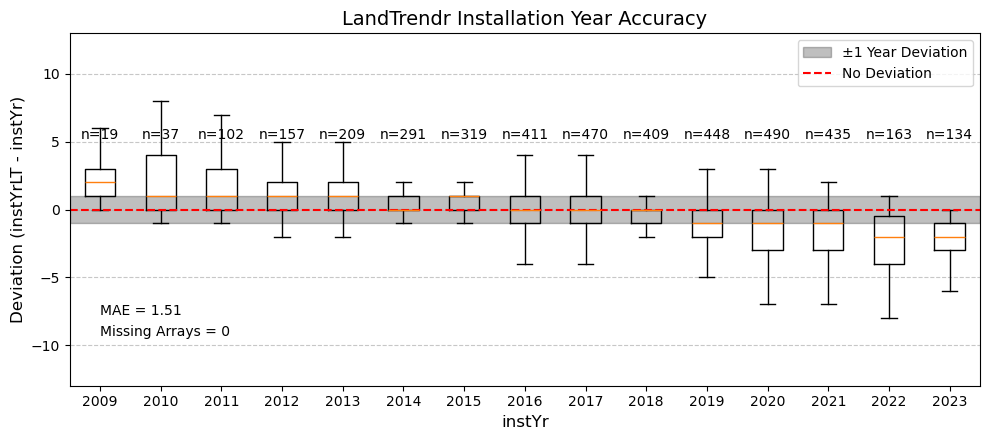

In [4]:
# Call lt_data
lt_data = pd.read_csv(os.path.join(derivedTemp_path, 'GMSEUS_Arrays_instYr_LandTrendr.csv'))

# Calculate the deviation
lt_data['deviation'] = lt_data['instYrLT'] - lt_data['instYr']

# Remove any rows where instYrLT is -9999 or instYr is -9999
lt_data_noNull = lt_data[(lt_data['instYrLT'] != -9999) & (lt_data['instYr'] != -9999)]

# Drop rows where Source is anything other than USPVDB
lt_data_noNull = lt_data_noNull[lt_data_noNull['Source'] == 'USPVDB']

# Print the total number of arrays with a newly detected installation year
print('Number of arrays with a newly detected installation year:', lt_data_noNull['deviation'].value_counts().sum())

# Print the mean absolute deviation
print('Mean Absolute Error:', lt_data_noNull['deviation'].abs().mean())

# Create a list of deviation values grouped by instYr and count the number of data points in each group
data = [lt_data_noNull[lt_data_noNull['instYr'] == year]['deviation'] for year in range(2009, 2024)]
counts = [len(group) for group in data]

# Plot the boxplot without showing outliers
plt.figure(figsize=(10, 4.5))
# Add a shaded black (alpha = 0.25) that is plus or minus 1 year from the 0 line
plt.axhspan(-1, 1, color='black', alpha=0.25, label='±1 Year Deviation')

# Create the boxplot
plt.boxplot(data, positions=range(2009, 2024), widths=0.5, showfliers=False)

# Add the count (N) above each box
for i, count in enumerate(counts):
    plt.text(2009 + i, 5, f'n={count}', ha='center', va='bottom', fontsize=10)

# In the lower left corner, add the MAE and the difference between lt_data nrows with instYr and instYrLT values not equal to -9999 and source USPVDB, and the nrows of lt_data_noNull
plt.text(2009, -7, f'MAE = {lt_data_noNull["deviation"].abs().mean():.2f}', ha='left', va='top', fontsize=10)
plt.text(2009, -8.5, f'Missing Arrays = {lt_data[(lt_data['instYr'] != -9999) & (lt_data["Source"] == "USPVDB")].shape[0] - lt_data_noNull.shape[0]}', ha='left', va='top', fontsize=10)

# Set x and y limits
plt.xlim(2008.5, 2023.5)
plt.ylim(-13, 13)

# Add labels, title, and grid
plt.xlabel('instYr', fontsize=12)
plt.ylabel('Deviation (instYrLT - instYr)', fontsize=12)
plt.title('LandTrendr Installation Year Accuracy', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add a 0 line (no deviation)
plt.axhline(y=0, color='red', linestyle='--', linewidth=1.5, label='No Deviation')

# Add a legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

### Plot LandTrendr Deviation for All Indices

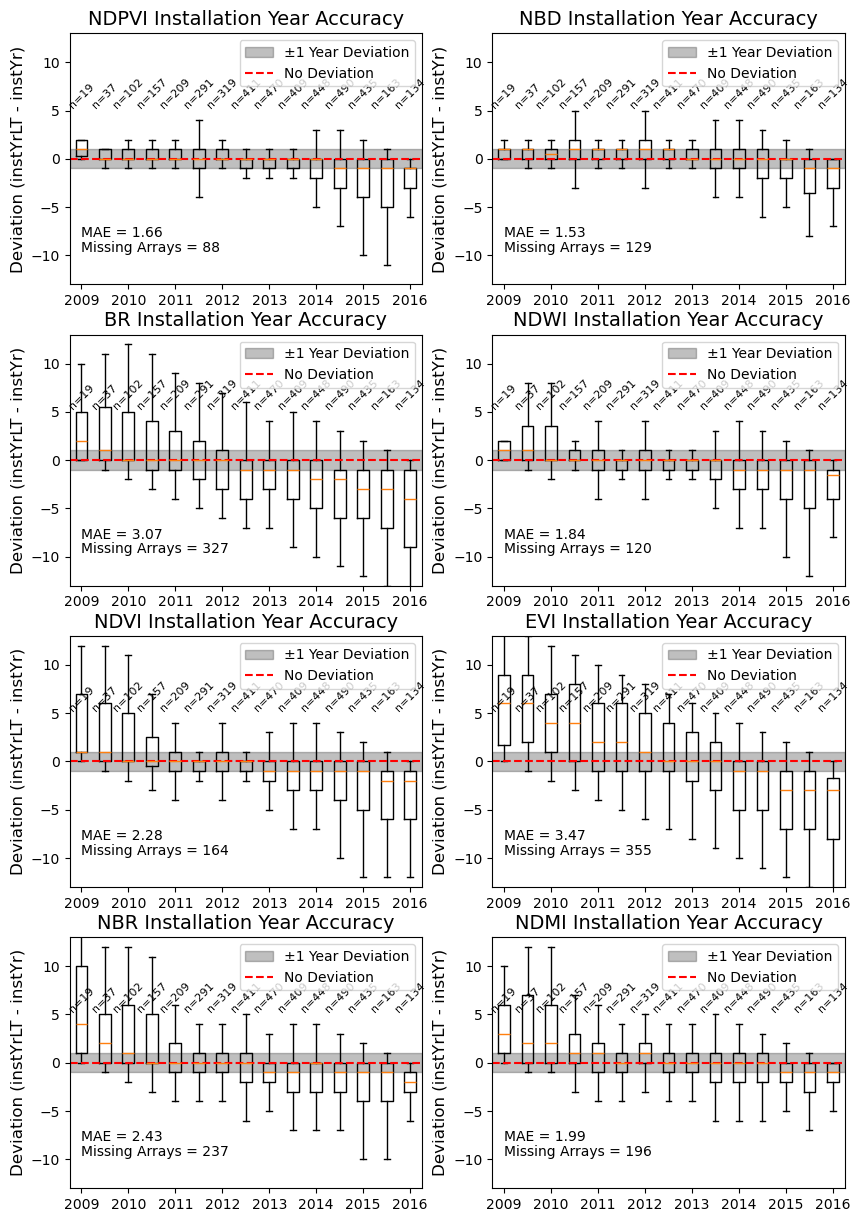

In [9]:
# Create the above graph, but for each index in a 4 row by 2 column grid
fig, axs = plt.subplots(4, 2, figsize=(10, 15))

# Iterate over each index
for i, index in enumerate(indices):
    # Calculate the deviation for the index
    lt_data['deviation'] = lt_data[f'instYrLT_{index}'] - lt_data['instYr']

    # Remove any rows where instYrLT is -9999 or instYr is -9999
    lt_data_noNull = lt_data[(lt_data[f'instYrLT_{index}'] != -9999) & (lt_data['instYr'] != -9999)]

    # Drop rows where Source is anything other than USPVDB
    lt_data_noNull = lt_data_noNull[lt_data_noNull['Source'] == 'USPVDB']

    # Create a list of deviation values grouped by instYr and count the number of data points in each group
    data = [lt_data_noNull[lt_data_noNull['instYr'] == year][f'deviation'] for year in range(2009, 2024)]

    # Plot the boxplot without showing outliers
    axs[i // 2, i % 2].axhspan(-1, 1, color='black', alpha=0.25, label='±1 Year Deviation')
    axs[i // 2, i % 2].boxplot(data, positions=range(2009, 2024), widths=0.5, showfliers=False)

    # Add the count (N) above each box, angle this text to be more readable by rotating it 45 degrees and make
    for j, count in enumerate(counts):
        axs[i // 2, i % 2].text(2009 + j, 5, f'n={count}', ha='center', va='bottom', fontsize=8, rotation=45)

    # In the lower left corner, add the MAE and the difference between lt_data nrows with instYr and instYrLT values not equal to -9999 and source USPVDB, and the nrows of lt_data_noNull
    axs[i // 2, i % 2].text(2009, -7, f'MAE = {lt_data_noNull[f"deviation"].abs().mean():.2f}', ha='left', va='top', fontsize=10)
    axs[i // 2, i % 2].text(2009, -8.5, f'Missing Arrays = {lt_data[(lt_data["instYr"] != -9999) & (lt_data["Source"] == "USPVDB")].shape[0] - lt_data_noNull.shape[0]}', ha='left', va='top', fontsize=10)

    # Set x and y limits, and ensure only every other year is shown on the x-axis
    axs[i // 2, i % 2].set_xlim(2008.5, 2023.5)
    axs[i // 2, i % 2].set_ylim(-13, 13)
    axs[i // 2, i % 2].set_xticks(range(2009, 2024, 2))

    # Add labels, title, and grid
    axs[i // 2, i % 2].set_xlabel('', fontsize=12)
    axs[i // 2, i % 2].set_ylabel('Deviation (instYrLT - instYr)', fontsize=12)
    axs[i // 2, i % 2].set_title(f'{index} Installation Year Accuracy', fontsize=14)

    # Add a 0 line (no deviation)
    axs[i // 2, i % 2].axhline(y=0, color='red', linestyle='--', linewidth=1.5, label='No Deviation')

    # Add a legend
    axs[i // 2, i % 2].legend()

# Export the plot
plt.savefig(os.path.join(figure_path, 'LandTrendr_Installation_Year_Accuracy.png'))

### Assign LandTrendr Installation Year, Fill Gaps in instYr, and Dissolve Exloded Arrays (SAM) by Year and arrayID

In [21]:
# Call gmseusArraysInstYr that has been spatially joined with point data
gmseusArraysInstYr = gpd.read_file(gmseusArraysInstYrPathPointCheckedPath)

# Call LandTrendr data
lt_data = pd.read_csv(lt_data_path)

# We exploded all grouped arrays in script5 so that we can merge them based on install year. To rectify this here, order both datasets by arrayID and set a tempID that is 1 through df length
gmseusArraysInstYr = gmseusArraysInstYr.sort_values(by='arrayID').reset_index(drop=True)
gmseusArraysInstYr['tempID'] = np.arange(1, len(gmseusArraysInstYr) + 1)
lt_data = lt_data.sort_values(by='arrayID').reset_index(drop=True)
lt_data['tempID'] = np.arange(1, len(lt_data) + 1)

# Merge the two datasets by arrayID
gmseusArraysInstYr = gmseusArraysInstYr.merge(lt_data[['tempID', 'instYrLT']], on='tempID', how='left')

# Fill NaN values in instYr with -9999
gmseusArraysInstYr['instYr'] = gmseusArraysInstYr['instYr'].fillna(-9999)

# Because CCVPV used a similar but less robust method (one index, and fastest LT), set all instYr values to -9999 for Source = 'CCVPV' to be replaced with instYrLT
gmseusArraysInstYr['instYr'] = gmseusArraysInstYr['instYr'].where(gmseusArraysInstYr['Source'] != 'CCVPV', -9999)

# Where gmseusArraysInstYr['instYr'] is -9999, replace with instYrLT
gmseusArraysInstYr['instYr'] = gmseusArraysInstYr['instYr'].where(gmseusArraysInstYr['instYr'] != -9999, gmseusArraysInstYr['instYrLT'])

# Print the total number of arrays with an installation year
print('Number of arrays with an installation year:', gmseusArraysInstYr[gmseusArraysInstYr['instYr'] != -9999].shape[0])

# Print the total number of arrays without an installation year
print('Number of arrays without an installation year:', gmseusArraysInstYr[gmseusArraysInstYr['instYr'] == -9999].shape[0])

# Get a temporary df where instYr and instYrLT are not -9999, and print the mean absolute error for all arrays, and those with Source = 'USPVDB'
gmseusArraysInstYr_noNull = gmseusArraysInstYr[(gmseusArraysInstYr['instYrLT'] != -9999) & (gmseusArraysInstYr['instYr'] != -9999)]
print('Mean Absolute Error ALL:', np.mean(np.abs(gmseusArraysInstYr_noNull['instYr'] - gmseusArraysInstYr_noNull['instYrLT'])))
gmseusArraysInstYr_noNull = gmseusArraysInstYr_noNull[gmseusArraysInstYr_noNull['Source'] == 'USPVDB']
print('Mean Absolute Error USPVDB:', np.mean(np.abs(gmseusArraysInstYr_noNull['instYr'] - gmseusArraysInstYr_noNull['instYrLT'])))

# Export the final instYr dataset (custom path)
gmseusArraysInstYr.to_file(os.path.join(derivedTemp_path, 'GMSEUS_Arrays_instYr_joined.shp'))

Number of arrays with an installation year: 12529
Number of arrays without an installation year: 7
Mean Absolute Error ALL: 0.922014687100894
Mean Absolute Error USPVDB: 1.5061998541210795


# Compile a semi-final GM-SEUS Array Dataset Grouped By Installation Year
In `script5`, we exploded array shapes that originally were gropued into possibly erroneous arrays (because of low imagery resolution).\
Here, we will group these back into array shapes only if they share a common installation year (or are small array subsections that recieved a different installation year).\
After assigning final panel-row and array attributes, we will further group by mount and proximity (below)

In [22]:
# Call gmseusArraysInstYr
gmseusArraysInstYr = gpd.read_file(os.path.join(derivedTemp_path, 'GMSEUS_Arrays_instYr_joined.shp'))

# Print original number of rows
print('Original number of rows:', gmseusArraysInstYr.shape[0])
# Print unique arrayIDs
print('Unique arrayIDs:', gmseusArraysInstYr['arrayID'].nunique())

# Get gmseusArraysInstYr that have unique arrayIDs and that have duplicate arrayIDs
gmseusArraysInstYrUnique = gmseusArraysInstYr[gmseusArraysInstYr['arrayID'].duplicated(keep=False) == False]
gmseusArraysInstYrDuplicate = gmseusArraysInstYr[gmseusArraysInstYr['arrayID'].duplicated(keep=False) == True]
# Split into unique and duplicate arrays based on arrayID
gmseusArraysInstYrUnique = gmseusArraysInstYr[~gmseusArraysInstYr['arrayID'].duplicated(keep=False)]
gmseusArraysInstYrDuplicate = gmseusArraysInstYr[gmseusArraysInstYr['arrayID'].duplicated(keep=False)]

# Create a new list to store processed duplicates
processed_duplicates = []

# Process only duplicate arrays
for arrayID in gmseusArraysInstYrDuplicate['arrayID'].unique():
    # Filter the rows for the current arrayID
    arrays = gmseusArraysInstYrDuplicate[gmseusArraysInstYrDuplicate['arrayID'] == arrayID]

    # Group by common instYr and set all other columns to their first value
    arrays = arrays.dissolve(by='instYr', aggfunc='first').reset_index()

    # Set a tempID to track individual rows
    arrays['tempID'] = np.arange(1, len(arrays) + 1)

    # Iterate through each array row
    for array in arrays.itertuples():
        # Get the area of the array
        area = array.geometry.area

        # If the area is below the minimum threshold
        if area < minPanelRowArea * minNumPanelRows:
            # Get other arrays to consider for merging
            other_arrays = arrays[arrays['tempID'] != array.tempID]

            if not other_arrays.empty:
                # Find the nearest array geometry
                nearest_geom = nearest_points(array.geometry, other_arrays.unary_union)[1]
                nearest_array = other_arrays[other_arrays.geometry == nearest_geom]

                if not nearest_array.empty:
                    # Merge the small array with the nearest array
                    merged_geometry = nearest_geom.union(array.geometry)

                    # Update the geometry of the nearest array
                    arrays.loc[arrays['geometry'] == nearest_geom, 'geometry'] = merged_geometry

                    # Drop the small array
                    arrays = arrays[arrays['tempID'] != array.tempID]

    # Append processed arrays to the results
    processed_duplicates.append(arrays)

# Combine processed duplicates into a single GeoDataFrame
processed_duplicates = gpd.GeoDataFrame(pd.concat(processed_duplicates, ignore_index=True))

# Combine processed duplicates with unique arrays into the final result
gmseusArraysFinal = gpd.GeoDataFrame(pd.concat([gmseusArraysInstYrUnique, processed_duplicates], ignore_index=True))

# Print final results
print('Number of rows after processing:', gmseusArraysFinal.shape[0])

# Add a new total array area column
gmseusArraysFinal['totArea'] = gmseusArraysFinal['geometry'].area

# Add a new arrayID column that is 1 through the length of the dataset
gmseusArraysFinal['arrayID'] = np.arange(1, len(gmseusArraysFinal) + 1)

# Get a temporary df where instYr and instYrLT are not -9999, and print the mean absolute error for all arrays, and those with Source = 'USPVDB'
gmseusArraysInstYr_noNull = gmseusArraysFinal[(gmseusArraysFinal['instYrLT'] != -9999) & (gmseusArraysFinal['instYr'] != -9999)]
print('Mean Absolute Error ALL:', np.mean(np.abs(gmseusArraysInstYr_noNull['instYr'] - gmseusArraysInstYr_noNull['instYrLT'])))
gmseusArraysInstYr_noNull = gmseusArraysInstYr_noNull[gmseusArraysInstYr_noNull['Source'] == 'USPVDB']
print('Mean Absolute Error USPVDB:', np.mean(np.abs(gmseusArraysInstYr_noNull['instYr'] - gmseusArraysInstYr_noNull['instYrLT'])))

# Export the final instYr filled dataset (custom path)
gmseusArraysFinal.to_file(os.path.join(derivedTemp_path, 'GMSEUS_Arrays_instYr_filled.shp'))

Original number of rows: 12536
Unique arrayIDs: 11959
Number of rows after processing: 12182
Mean Absolute Error ALL: 0.9410218498439297
Mean Absolute Error USPVDB: 1.5061998541210795


# Final Panel-Row Attributes for Rows and Array Averages and Sums
This includes final arrayID, pnlArea, rowWidth, rowLength, rowAzimuth, rowMount, and rowSpace

### Assign Final Panel-Row Attributes to Panel-Rows

In [ ]:
# This cell requires over 500 (~8 hours) minutes to run. 

# Call gmseus panels
gmseusPanels = gpd.read_file(gmseusPanelsCombinedPath)

# Call in gmseus arrays with installation year
gmseusArrays = gpd.read_file(os.path.join(derivedTemp_path, 'GMSEUS_Arrays_instYr_filled.shp'))

# If gmseusPanels already contains the arrayID, mount, azimuth, length, width, area, or rowSpace columns, drop them. Drop their updated names if they exist as well
gmseusPanels = gmseusPanels.drop(columns=['arrayID', 'mount', 'azimuth', 'longEdge', 'shortEdge', 'area', 'rowSpace'], errors='ignore')
gmseusPanels = gmseusPanels.drop(columns=['rowMount', 'rowAzimuth', 'rowLength', 'rowWidth', 'rowArea'], errors='ignore')

# Keep only the following columns: 'nativeID', 'Source', 'PnlSource', 'panelID', 'area', 'geometry'
#gmseusPanels = gmseusPanels[['nativeID', 'Source', 'PnlSource', 'panelID', 'area', 'geometry']] 

# Set the rowArea column to the area of the panel
gmseusPanels['rowArea'] = gmseusPanels['geometry'].area

# Spatially join gmseus arrays to panels, copy the arrayID to the panels, and drop the index columns. 
gmseusPanels = gpd.sjoin(gmseusPanels, gmseusArrays[['arrayID', 'geometry']], how='left', predicate='intersects')
gmseusPanels  = gmseusPanels.reset_index(drop=True)
gmseusPanels  = gmseusPanels.drop(columns=['index_left', 'index_right'], errors='ignore')

# Get panel-row mount, azimuth, length, and width attributes from assignMountType function
gmseusPanels[['mount', 'azimuth', 'lengthRatio', 'shortEdge', 'longEdge']] = gmseusPanels.apply(assignMountType, axis=1, result_type='expand')

# Rename azimuth to rowAzimuth, shortEdge to rowWidth, longEdge to rowLength, and mount to rowMount
gmseusPanels = gmseusPanels.rename(columns={'azimuth': 'rowAzimuth', 'shortEdge': 'rowWidth', 'longEdge': 'rowLength', 'mount': 'rowMount'})

# Drop lengthRatio
gmseusPanels = gmseusPanels.drop(columns=['lengthRatio'], errors='ignore')

# Get the inter-row spacing for each panel in the azimuthal direction (or any direction for dual-axis trackers)
#gmseusPanels['rowSpace'] = 3
gmseusPanels = calculateRowSpacing(gmseusPanels)
gmseusPanels = gmseusPanels.reset_index(drop=True)

# Round rowAzimuth, rowWidth, rowLength, rowArea, and rowSpace to 2 decimal places
gmseusPanels['rowAzimuth'] = gmseusPanels['rowAzimuth'].round(2)
gmseusPanels['rowWidth'] = gmseusPanels['rowWidth'].round(2)
gmseusPanels['rowLength'] = gmseusPanels['rowLength'].round(2)
gmseusPanels['rowArea'] = gmseusPanels['rowArea'].round(2)
gmseusPanels['rowSpace'] = gmseusPanels['rowSpace'].round(2)

# Export the final dataset
gmseusPanels.to_file(gmseusPanelsFinalPath)

### Assign Final Panel-Row Attributes to Arrays

In [13]:
# Recall gmseusPanels and gmseusArrays
gmseusPanels = gpd.read_file(gmseusPanelsFinalPath)
gmseusArrays = gpd.read_file(os.path.join(derivedTemp_path, 'GMSEUS_Arrays_instYr_filled.shp')) 

# If any of these columns already exist in gmseusArrays, drop them
gmseusArrays = gmseusArrays.drop(columns=['numRow', 'totRowArea', 'avgLength', 'avgWidth', 'avgSpace', 'mount', 'avgAzimuth'], errors='ignore')

# Get rowNum, totRowArea, lengthAvg, widthAvg, and spaceAvg for each array from gmseusPanels
numRows = gmseusPanels.groupby('arrayID').size().reset_index(name='numRow')
totRowAreas = gmseusPanels.groupby('arrayID')['rowArea'].sum().reset_index(name='totRowArea')
avgLengths = gmseusPanels.groupby('arrayID')['rowLength'].median().reset_index(name='avgLength')
avgWidths = gmseusPanels.groupby('arrayID')['rowWidth'].median().reset_index(name='avgWidth')
avgSpaces = gmseusPanels.groupby('arrayID')['rowSpace'].median().reset_index(name='avgSpace')

# Merge gmsesuArrays with the new columns by arrayID
gmseusArrays = gmseusArrays.merge(numRows[['arrayID', 'numRow']], on='arrayID', how='left')
gmseusArrays = gmseusArrays.merge(totRowAreas[['arrayID', 'totRowArea']], on='arrayID', how='left')
gmseusArrays = gmseusArrays.merge(avgLengths[['arrayID', 'avgLength']], on='arrayID', how='left') 
gmseusArrays = gmseusArrays.merge(avgWidths[['arrayID', 'avgWidth']], on='arrayID', how='left')
gmseusArrays = gmseusArrays.merge(avgSpaces[['arrayID', 'avgSpace']], on='arrayID', how='left')

# Mount and azimuthAvg have to be treated differently. 
# For mount, gmseusPanels grouped by arrayID could contain any or all of these classes: 'fixed_axis', 'single_axis', or 'dual_axis'.
# If the array contains more than 90% one class, set mount as that majority class. Otherwise, set mount as 'mixed_' + a letter combination of the classes (e.g., mixed_fs for fixed_axis and single_axis, or mixed_fsd for all three mount types).
mounts = gmseusPanels.groupby('arrayID')['rowMount'].apply(getArrayMount, include_groups = False).reset_index(name='mount')
gmseusArrays = gmseusArrays.merge(mounts[['arrayID', 'mount']], on='arrayID', how='left')

# For azimuth, fixed- and dual-axis arrays have an avgAzimuth of the median of rowAzimuth. Single-axis arrays have an avgAzimuth of the median of rowAzimuth IF rowAzimuth is  + 90 degrees. Mixed arrays should be ignored, but have an avearge azimuth of the median of rowAzimuth.
azimuths = gmseusPanels.groupby('arrayID').apply(getArrayAzimuth, include_groups = False).reset_index(name='avgAzimuth')
gmseusArrays = gmseusArrays.merge(azimuths[['arrayID', 'avgAzimuth']], on='arrayID', how='left')

# Change the cap_mw column name to capMW
gmseusArrays = gmseusArrays.rename(columns={'cap_mw': 'capMW'})

# Export the final rowAttribute dataset (custom path)
gmseusArrays.to_file(os.path.join(derivedTemp_path, 'GMSEUS_Arrays_rowAttributes.shp'))

f:\Python_Envs\BigPanel\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
f:\Python_Envs\BigPanel\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


# Check Existing Datasets for Remaining Desired Array Attributes
* *Already converted* indicates that this attribute has already been acquired, renamed and QA/QC'ed to match the schema, and saved in our preprocessing in `script1`.
* Due to manual digitization and other processing operations, we re-attach all attributes *here* in case any were forgone in processing since `script1`. 
* Dataset attribute contributions are ordered by percieved quality, and thus attribution ranking to the final GM-SEUS dataset.
* CWSD is not included here since the only contributed attribute is installation year (merged in prior code chunks)
* We do not include attributes from all datasets for quality control purposes, even if there are no high-quality dataset attribution. We do this because unless the metadata source was derived from perimt data or high-quality sub-array metadata extraction, we assume our methods used here are more accurate. 
    * Some datasets have extensive methods for certain attributes (e.g., GEM GSPT derivation of capacity is array by array intensive investiation of web sources), despite not having all permit level data. We denote dataset attributes that exist but that we do not use by <span style="background-color: #FF2800">*color*</span> and explain in line.

**Installed Capacity**
* USPVDB: `p_cap_dc` & `p_cap_ac` (already converted in uspvdb_poly.shp) -- DC & AC (we will use DC here)
* InSPIRE: `System Size` (already converted in inspire_point.shp) -- DC
* LBNL-USS: `Solar Capacity MW-DC` (already converted in lbnlUss_point.shp) -- DC
* SolarPaces: `Capacity_MW` (already converted in solarPaces_point.shp) -- e or electric, synonomus to AC?
* PV-DAQ: `system_size` (already converted in pvdaq_point.shp) -- DC
* GSPT: `Capacity (MW)` (already converted in gspt_point.shp) -- DC? (unceratin)
* GPPDB: `capacity_mw` (already converted in gppdb_point.shp) -- DC? (uncertain)
* CCVPV: `TPVPp` (already converted in ccvpv_poly.shp) -- DC
* <span style="background-color: #FF2800">*SAM*</span>: `capacity_mw` (already converted in sam_poly.shp) -- AC -- Derived by course Regional GCR and inverter loading ratio (ILR) and for often erronouesly large array areas (due to coarse imagery)
* <span style="background-color: #FF2800">*OSM*</span>: `plant:output:electricity` (already converted in osm_poly.shp) -- DC (defined as: *peak rated output capacity*) -- crowd sourced information with unclear accuracy of reporting (concerns between AC/DC, original vs expanded capacity, etc.)

**Module Type**
* SolarPaces: inherent in the dataset -- CSP (already converted in solarPaces_point.shp) -- This takes precedent for csp arrays
* USPVDB: `p_tech_sec` (already converted in uspvdb_poly.shp)
* LBNL-USS: `Solar Tech Sub` (already converted in lbnlUss_point.shp)
* GSPT:

**Module Efficiency**
* USPVDB: 
* CCVPV: 

**Module Tilt**
* USPVDB: `p_tilt`
* CCVPV: `Bopt`

**Azimuth**
* USPVDB: `p_azimuth` (already converted in uspvdb_poly.shp)
* LBNL-USS: `Azimuth` (already converted in lbnlUss_point.shp)
* <span style="background-color: #FF2800">*OSM*</span>: `generator:orientation` (we have not yet acquired this from OSM, need to update `script0`) -- Have not pulled this information from OSM yet, but there remains concern over quality of crowd sourced information when attribute is not clearly explained

**Ground Cover Ratio**
* CCVPV: `PF`

**Mount Technology**
* USPVDB: `p_axis` (already converted in uspvdb_poly.shp)
* InSPIRE: `Type Of Array` (already converted in inspire_point.shp)
* LBNL-USS: `Tracking Type` (already converted in lbnlUss_point.shp)
* CCVPV: `Class` (already converted in ccvpv_poly.shp)
* SolarPaces: assumed from `Technology` (already converted in solarPaces_point.shp)

**Agrivoltaic Type**
* InSPIRE: `Habitat Type` (already converted in inspire_point.shp)
* <span style="background-color: #FF2800">*USPVDB*</span>: `AVtype` (alreday converted in uspvdb_poly.shp) -- Derived from InSPIRE

In [ ]:
# Call all processed datasets
gmseusArrays = gpd.read_file(os.path.join(derivedTemp_path, r'GMSEUS_Arrays_rowAttributes.shp'))
uspvdb = gpd.read_file(os.path.join(derivedTemp_path, r'uspvdb_poly.shp'))
ccvpv = gpd.read_file(os.path.join(derivedTemp_path, r'ccvpv_poly.shp'))
sam = gpd.read_file(os.path.join(derivedTemp_path, r'sam_poly.shp'))
osm = gpd.read_file(os.path.join(derivedTemp_path, r'osm_poly.shp'))
inspire = gpd.read_file(os.path.join(derivedTemp_path, r'inspire_point.shp'))
lnblUse = gpd.read_file(os.path.join(derivedTemp_path, r'lbnlUss_point.shp'))
pvdaq = gpd.read_file(os.path.join(derivedTemp_path, r'pvdaq_point.shp'))
solarPaces = gpd.read_file(os.path.join(derivedTemp_path, r'solarPaces_point.shp'))
gspt = gpd.read_file(os.path.join(derivedTemp_path, r'gspt_point.shp'))
gppdb = gpd.read_file(os.path.join(derivedTemp_path, r'gppdb_point.shp'))

## Check Installed Capacity

## Check 

# Estimate Ground Cover Ratio
This includes two different definitions of GCR: 
* GCR1 is the ratio of the total panel-row area to total array area (more accurately, total array area is panel-row area and the space between panel-rows)
* GCR2 is the ratio of the average panel-row width (avgWidth) to the horizontal ground distance between identical panel-rows points, defined as the sum of avgWidth and avgSpace

In [ ]:
# Call gmseus arrays and panels
gmseusArrays = gpd.read_file(os.path.join(derivedTemp_path, r'GMSEUS_Arrays_rowAttributes.shp'))
gmseusPanels = gpd.read_file(gmseusPanelsFinalPath)

# If either GCR1 or GCR2 already exist in gmseusArrays, drop them
gmseusArrays = gmseusArrays.drop(columns=['GCR1', 'GCR2'], errors='ignore')

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Calculate GCR1 and GCR2 for arrays with panel-rows

# Create arrays from panels (to acquire total delineated area and not bias GCR if there were omitted panels)
gmseusPanelsArrays = createArrayFromPanels(gmseusPanels, panelArrayBuff, 'arrayID', 'rowArea')

# Calculate the area of each gmseusPanelsArrays array as totalArea′, and add as new column to gmseusArrays matching by arrayID
gmseusPanelsArrays['totAreaPrime'] = gmseusPanelsArrays['geometry'].area
gmseusArrays = gmseusArrays.merge(gmseusPanelsArrays[['arrayID', 'totAreaPrime']], on='arrayID', how='left')

# Set GCR1 attribute as the ratio of totRowArea to totArea rounded to four decimal places
gmseusArrays['GCR1'] = (gmseusArrays['totRowArea'] / gmseusArrays['totAreaPrime']).round(4)

# Drop totAreaPrime
gmseusArrays = gmseusArrays.drop(columns=['totAreaPrime'], errors='ignore')

# Set GCR2 attribute as the ratio of: rowWidth to the sum of avgWidth and rowSpace
gmseusArrays['GCR2'] = (gmseusArrays['avgWidth'] / (gmseusArrays['avgWidth'] + gmseusArrays['avgSpace'])).round(4)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Estimate GCR1 and GCR2 for arrays without panel-rows

# Get the latitude and longitude of the centroid of each array as an attribute
gmseusArrays['latitude'] = gmseusArrays['geometry'].centroid.y
gmseusArrays['longitude'] = gmseusArrays['geometry'].centroid.x

# Save gmseusArrays to a temporary file called SAVE
#SAVE = gmseusArrays.copy()

# Create a multiple linear regression model between latitude and longitude to predict GCR1 and GCR2 for each mount type and modType
def spatiallyExtrapolateGCR(df):
    # Define PV and CSP mod type groups
    modGroups = {'PV': ['c-si', 'thin-film'], 'CSP': ['csp']}

    # Get unique mount types
    mountTypes = df['mount'].unique()

    # Iterate over each mount type
    for mountType in mountTypes:
        # Filter data for the current mount type or consider all data if mountType is None
        if mountType is None:
            print("Not all arrays contain a mount type. For these, we will arrays of all mount types for training and prediction.")
            mountData = df
        else:
            mountData = df[df['mount'] == mountType]

        # Iterate over PV and CSP mod type groups
        for modGroup, modTypes in modGroups.items():
            # Filter data for the current mod type group
            modData = mountData[mountData['modType'].isin(modTypes)]

            # Separate into withGCR and withoutGCR subsets
            withGCR = modData.dropna(subset=['numRow'])
            withoutGCR = modData[modData['numRow'].isnull()]

            # Use broader mount type dataset if not enough data for this mod group
            if withGCR.empty: # or withoutGCR.empty:
                print(f"Insufficient data for mount: {mountType}, modGroup: {modGroup}. Using broader dataset.")
                withGCR = mountData.dropna(subset=['numRow'])
                withoutGCR = mountData[mountData['numRow'].isnull()]

            # Drop rows with missing latitude, longitude, GCR1, or GCR2
            withGCR = withGCR.dropna(subset=['latitude', 'longitude', 'GCR1', 'GCR2'])
            withoutGCR = withoutGCR.dropna(subset=['latitude', 'longitude'])

            # Proceed if we have training and prediction data
            if not withGCR.empty and not withoutGCR.empty:
                # Prepare training data for GCR1 and GCR2
                xTrain = withGCR[['latitude', 'longitude']]
                yTrainGCR1 = withGCR['GCR1']
                yTrainGCR2 = withGCR['GCR2']

                # Train regression models for GCR1 and GCR2
                modelGCR1 = LinearRegression()
                modelGCR2 = LinearRegression()
                modelGCR1.fit(xTrain, yTrainGCR1)
                modelGCR2.fit(xTrain, yTrainGCR2)

                # Prepare data for prediction
                xPredict = withoutGCR[['latitude', 'longitude']]

                # Predict and update withoutGCR using loc
                withoutGCR['GCR1'] = modelGCR1.predict(xPredict)
                withoutGCR['GCR2'] = modelGCR2.predict(xPredict)

                # Merge the updated rows back
                df = df.merge(
                    withoutGCR[['arrayID', 'GCR1', 'GCR2']],
                    on='arrayID',
                    how='left',
                    suffixes=('', '_new'))
                df['GCR1'] = df['GCR1_new'].combine_first(df['GCR1'])
                df['GCR2'] = df['GCR2_new'].combine_first(df['GCR2'])
                df = df.drop(columns=['GCR1_new', 'GCR2_new'])

    # Set the max GCR1 and GCR2 values to 1
    df['GCR1'] = df['GCR1'].clip(upper=1)
    df['GCR2'] = df['GCR2'].clip(upper=1)

    # Round GCR1 and GCR2 to four decimal places
    df['GCR1'] = df['GCR1'].round(4)
    df['GCR2'] = df['GCR2'].round(4)

    return df

# Apply the function to your data
gmseusArraysGCRlocal = spatiallyExtrapolateGCR(gmseusArrays)

# Where GCR1 is null in gmseusArrays, replace with GCR1 from gmseusArraysGCRlocal by arrayID
gmseusArrays['GCR1'] = gmseusArrays['GCR1'].where(gmseusArrays['GCR1'].notnull(), gmseusArraysGCRlocal['GCR1'])

# Print the number of gmseusArrays with GC1 not null
print('Number of arrays with GCR1:', gmseusArrays[gmseusArrays['GCR1'].notnull()].shape[0])

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Export the final dataset

# Export the final GCR dataset
gmseusArrays.to_file(os.path.join(derivedTemp_path, r'GMSEUS_Arrays_GCR.shp'))

Not all arrays contain a mount type. For these, we will arrays of all mount types for training and prediction.
Insufficient data for mount: mixed_dfs, modGroup: CSP. Using broader dataset.
Number of arrays with GCR1: 12182


# Estimate Installed Capacity
* Solar PV (c-Si and thin-film)
    * Many arrays have module-level data. If they don't we assume that they are solar PV c-si, the vast majority of existing solar arrays. 
    * For PV, we will use either USPVDB EIA Form 860 Module efficiency data or LBNL Tracking the Sun report from [Barbose et al., 2024](https://emp.lbl.gov/publications/tracking-sun-pricing-and-design-3) for assuming panel efficiency through time for solar PV (c-si and thin-film). 
* Solar CSP (Parabolic Trough, Linear Fresnel, Power Tower, Dish, Beam-Down Tower, or a hybrid)
    * For CSP solar arrays, we will use a conversion factor reccomentadation from [IEA](https://www.iea-shc.org/Data/Sites/1/publications/2023-07-Task64-New-Conversion-Factor.pdf) which is also shown in the [technical note](https://www.iea-shc.org/data/sites/1/documents/statistics/technical_note-new_solar_thermal_statistics_Conversion.pdf)
    * This is a 0.7 kWth per m^2 of aperture collector area to installed thermal capacity. This value is not reccomended to be applied to Tower plants, but we really don't have any other insight on how to calculate this.

## Solar PV (c-Si and thin-film)

### First, Acquire Annual Efficiency of C-Si and Thin-Film from LBNL Tracking The Sun Report

In [16]:
# Call TTS
tts = pd.read_csv(tts_path)

# Drop any rows where installation_date, ground_mounted, efficiency_module_1, or technology_module_1 is = -1
tts = tts[(tts['installation_date'] != -1) & (tts['ground_mounted'] != -1) & (tts['efficiency_module_1'] != -1) & (tts['technology_module_1'] != -1)]

# Select only rows where ground_mounted is = 1
tts = tts[tts['ground_mounted'] == 1]

# installation_date column is in the format: '15-Nov-2019', convert to datetime
tts['installation_date'] = pd.to_datetime(tts['installation_date'], format='%d-%b-%Y')

# Get the year from the installation_date
tts['instYr'] = tts['installation_date'].dt.year

# Select columns of interest
efficiency = tts.loc[:, ['instYr', 'efficiency_module_1', 'efficiency_module_2', 'efficiency_module_3', 'technology_module_1', 'technology_module_2', 'technology_module_3']]

# Module technologies are: 'Mono-c-Si', 'Multi-c-Si', 'Thin Film', 'a-Si', 'CdTe'. Add a new column (modType_1, modType_2, modType_3) which is c-si for 'Mono-c-Si' and 'Multi-c-Si', and thin-film for 'Thin Film', 'a-Si', and 'CdTe'.
efficiency.loc[efficiency['technology_module_1'].isin(['Mono-c-Si', 'Multi-c-Si']), 'modType_1'] = 'c-si'
efficiency.loc[efficiency['technology_module_1'].isin(['Thin Film', 'a-Si', 'CdTe']), 'modType_1'] = 'thin-film'
efficiency.loc[efficiency['technology_module_2'].isin(['Mono-c-Si', 'Multi-c-Si']), 'modType_2'] = 'c-si'
efficiency.loc[efficiency['technology_module_2'].isin(['Thin Film', 'a-Si', 'CdTe']), 'modType_2'] = 'thin-film'
efficiency.loc[efficiency['technology_module_3'].isin(['Mono-c-Si', 'Multi-c-Si']), 'modType_3'] = 'c-si'
efficiency.loc[efficiency['technology_module_3'].isin(['Thin Film', 'a-Si', 'CdTe']), 'modType_3'] = 'thin-film'

# Replace any efficiency_module and technology_module values of -1 with NaN. Use .loc
efficiency.loc[efficiency['efficiency_module_1'] == -1, 'efficiency_module_1'] = np.nan
efficiency.loc[efficiency['efficiency_module_2'] == -1, 'efficiency_module_2'] = np.nan
efficiency.loc[efficiency['efficiency_module_3'] == -1, 'efficiency_module_3'] = np.nan
efficiency.loc[efficiency['technology_module_1'] == -1, 'technology_module_1'] = np.nan
efficiency.loc[efficiency['technology_module_2'] == -1, 'technology_module_2'] = np.nan
efficiency.loc[efficiency['technology_module_3'] == -1, 'technology_module_3'] = np.nan

# Now, create a dataframe with the mean efficiency for each year and module type. Consider all three module types. effDF is a dataframe with columns: 'instYr', 'c-si', 'thin-film'. 
# Combine all module efficiencies and types into a single DataFrame for processing
efficiency_long = pd.concat([
    efficiency[['instYr', 'efficiency_module_1', 'modType_1']].rename(columns={'efficiency_module_1': 'efficiency', 'modType_1': 'modType'}),
    efficiency[['instYr', 'efficiency_module_2', 'modType_2']].rename(columns={'efficiency_module_2': 'efficiency', 'modType_2': 'modType'}),
    efficiency[['instYr', 'efficiency_module_3', 'modType_3']].rename(columns={'efficiency_module_3': 'efficiency', 'modType_3': 'modType'})
])

# Drop rows where efficiency is NaN
efficiency_long = efficiency_long.dropna(subset=['efficiency'])

# Group by year and module type, and calculate mean efficiency
mean_efficiency = efficiency_long.groupby(['instYr', 'modType'])['efficiency'].mean().reset_index()

# Pivot the table to have 'instYr' as rows and module types as columns
effDF = mean_efficiency.pivot(index='instYr', columns='modType', values='efficiency').reset_index()

# Remove column index name
effDF.columns.name = None

# Ensure that there are rows from instYr 1983 to 2024. 
effDF = effDF.set_index('instYr').reindex(range(1982, 2024)).reset_index()

# Interpolate, FFill, and BFill any NaN values
effDF['c-si'] = effDF['c-si'].interpolate()
effDF['thin-film'] = effDF['thin-film'].interpolate()
effDF['c-si'] = effDF['c-si'].ffill()
effDF['thin-film'] = effDF['thin-film'].ffill()
effDF['c-si'] = effDF['c-si'].bfill()
effDF['thin-film'] = effDF['thin-film'].bfill()

# Export the final dataset
effDF.to_csv(os.path.join(derivedTemp_path, 'pvEfficiency.csv'), index=False)

C:\Users\stidjaco\AppData\Local\Temp\ipykernel_13500\3650503404.py:2: DtypeWarning: Columns (1,2,3,8,11,15,16,18,20,29,32,35,38,39,40,41,42,43,44,45,46,53,54,56,57,59,60,63,64,65,66,67,68,74,75,79,80) have mixed types. Specify dtype option on import or set low_memory=False.
  tts = pd.read_csv(tts_path)


### Estimate Installed Peak Capacity
* Use Installation Year, Temporal Module Efficiency, and Panel-Row Area (using average GCR at latitutde and mount tech from the GM-SEUS Array database to estimate panel area) to estimate PV capacity (c-si and thin-film)
* Use an estimation of effective total panel-row area and the 0.7 kWth m^-2 conversion factor to estimate CSP capacity (Parabolic Trough, Linear Fresnel, Power Tower, Dish, Beam-Down Tower, or a hybrid)

In [ ]:
# Call gmseus arrays
gmseusArrays = gpd.read_file(os.path.join(derivedTemp_path, r'GMSEUS_Arrays_GCR.shp'))

# If effInit or capMWest already exist in gmseusArrays, drop them
gmseusArrays = gmseusArrays.drop(columns=['effInit', 'capMWest'], errors='ignore')

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Calculate PV Capacity (MWdc)

# Call pvEfficiency
effDF = pd.read_csv(os.path.join(derivedTemp_path, 'pvEfficiency.csv'))

# Set Gstc
Gstc = 1 # kW/m^2

# Melt effDf into two columns: 'instYr' and 'modType'
effDF = effDF.melt(id_vars='instYr', var_name='modType', value_name='effInit')

# ASSUME that permitted efficiency is from the year prior to completed installation. Thus, add 1 to instYr in effDF (e.g., 2019 efficiency is for 2020 installations)
#effDF['instYr'] = effDF['instYr'] + 1

# Merge the efficiency data with gmseusArrays by [instYr, modType]
gmseusArrays = gmseusArrays.merge(effDF, on=['instYr', 'modType'], how='left')

# Estimate capacity (MWdc) for arrays with panel-rows
gmseusArrays['capMWest'] = (gmseusArrays['totRowArea'] * gmseusArrays['effInit'] * Gstc) / 1000

# Print number of capMWest null
print('Number of capMWest null:', gmseusArrays['capMWest'].isnull().sum())

# Where capMWest is NaN, estimate capacity (MWdc) for arrays without panel-rows. 
gmseusArrays['capMWest'] = gmseusArrays['capMWest'].where(gmseusArrays['capMWest'].notnull(), (gmseusArrays['totArea'] * gmseusArrays['GCR1'] * gmseusArrays['effInit'] * Gstc) / 1000)

# Where modType is equal to 'csp', set capMWest to NaN and effInit to NaN
gmseusArrays['capMWest'] = gmseusArrays['capMWest'].where(gmseusArrays['modType'] != 'csp', np.nan)
gmseusArrays['effInit'] = gmseusArrays['effInit'].where(gmseusArrays['modType'] != 'csp', np.nan)

# Print number of capMWest null
print('Number of capMWest null:', gmseusArrays['capMWest'].isnull().sum())

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Calculate CSP Capacity (MWth)

# Set conversion factor for CSP capacity
cspCF = 0.7 # kWth m^-2

# Create a new column 'apertureArea' which is equal to totRowArea
# If mount type is fixed_axis, single_axis, or mixed_fs, set aperatureArea to: 0.5 * Circumference of a circle with a diameter = totRowArea, else retain totRowArea
gmseusArrays['apertureArea'] = gmseusArrays['totRowArea']
gmseusArrays['apertureArea'] = gmseusArrays['apertureArea'].where(gmseusArrays['mount'].isin(['fixed_axis', 'single_axis', 'mixed_fs']), 0.5 * np.pi * np.sqrt(gmseusArrays['totRowArea'] / np.pi))

# If aperature area is NaN, use the same approch as above but replace totRowArea with (totArea * GCR1)
gmseusArrays['apertureArea'] = gmseusArrays['apertureArea'].where(gmseusArrays['apertureArea'].notnull(), 0.5 * np.pi * np.sqrt(gmseusArrays['totArea'] * gmseusArrays['GCR1'] / np.pi))

# Calculate the capacity of CSP arrays (MW) where modType is csp - (gmseusArrays['apertureArea'] * cspCF) / 1000
gmseusArrays['capMWest'] = gmseusArrays['capMWest'].where(gmseusArrays['modType'] != 'csp', (gmseusArrays['apertureArea'] * cspCF) / 1000)

# Drop apertureArea
gmseusArrays = gmseusArrays.drop(columns=['apertureArea'], errors='ignore')

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Export the final dataset

# Round capMWest to three decimal places
gmseusArrays['capMWest'] = gmseusArrays['capMWest'].round(3)

# Fill NaN in capMW with -9999
gmseusArrays['capMW'] = gmseusArrays['capMW'].fillna(-9999)

# Where capMW is NaN (here, -9999), fill with capMWest
gmseusArrays['capMW'] = gmseusArrays['capMW'].where(gmseusArrays['capMW'] != -9999, gmseusArrays['capMWest'])

# Export the final capacity dataset
gmseusArrays.to_file(os.path.join(derivedTemp_path, r'GMSEUS_Arrays_Capacity.shp'))

Number of capMWest null: 3816
Number of capMWest null: 85


In [18]:
# Print the number of arrays with capacitry < 1 MW
print('Number of arrays with capacity < 1 MW:', gmseusArrays[gmseusArrays['capMW'] < 1].shape[0])

# Print range in totArea for arrays with capacity < 1 MW
print('Range in totArea for arrays with capacity < 1 MW:', gmseusArrays[gmseusArrays['capMW'] < 1]['totArea'].min(), 'to', gmseusArrays[gmseusArrays['capMW'] < 1]['totArea'].max())

# Print the number of arrays with capacitry >= 1 MW
print('Number of arrays with capacity >= 1 MW:', gmseusArrays[gmseusArrays['capMW'] >= 5].shape[0])

# Print range in totArea for arrays with capacity >= 1 MW
print('Range in totArea for arrays with capacity >= 1 MW:', gmseusArrays[gmseusArrays['capMW'] >= 5]['totArea'].min(), 'to', gmseusArrays[gmseusArrays['capMW'] >= 5]['totArea'].max())

# Print sum of capMW
print('Sum of capMW:', gmseusArrays['capMW'].sum())

Number of arrays with capacity < 1 MW: 4766
Range in totArea for arrays with capacity < 1 MW: 17.361103377587625 to 388507.58441831404
Number of arrays with capacity >= 1 MW: 2948
Range in totArea for arrays with capacity >= 1 MW: 20.165996229987226 to 13735113.179678869
Sum of capMW: 145032.8227152038


# Set Final Columns, Version, and Export

In [25]:
# Call gmseus arrays and panels
gmseusArrays = gpd.read_file(os.path.join(derivedTemp_path, r'GMSEUS_Arrays_Capacity.shp'))
#gmseusPanels = gpd.read_file(gmseusPanelsFinalPath)

# Set version to gmseusArrays and gmseusPanels
gmseusArrays['version'] = version
#gmseusPanels['version'] = version

# Export the final datasets
gmseusArrays.to_file(gmseusArraysFinalPath)
#gmseusPanels.to_file(gmseusPanelsFinalPath)